In [4]:
import torch
import torch.nn as nn
from torch_snippets import *
from torchvision import transforms
from sklearn.model_selection import train_test_split
device = 'cuda' if torch.cuda.is_available() else 'cpu'
import cv2
import os
import matplotlib.pyplot as plt

# define the dataset class 

In [5]:
class segdata(Dataset):
    def __init__(self,split):
        if split=='train':
            self.items=os.listdir(r'C:\myfiles\semnatic segmentation\dataset1\images_prepped_train')
            self.masks=os.listdir(r'C:\myfiles\semnatic segmentation\dataset1\annotations_prepped_train')
        elif split=='test':
            self.items=os.listdir(r'C:\myfiles\semnatic segmentation\dataset1\images_prepped_test')
            self.masks=os.listdir(r'C:\myfiles\semnatic segmentation\dataset1\annotations_prepped_test')
        self.split = split
    def __len__(self):
        return len(self.masks) 
    def __getitem__(self,ix):
        temp=ix
        if self.split=='train':
            image=cv2.imread(os.path.join(r'C:\myfiles\semnatic segmentation\dataset1\images_prepped_train',self.items[temp]))
            image=cv2.resize(image,(224,224))
            image=torch.Tensor(image)
            #image=image.to(torch.uint8)
            image=torch.permute(image,(2,0,1))
            image=image.to(device)
            mask=cv2.imread(os.path.join(r'C:\myfiles\semnatic segmentation\dataset1\annotations_prepped_train',self.items[temp]),0)
            mask=cv2.resize(mask,(224,224))
            mask=torch.Tensor(mask).long()
            #mask=mask.to(torch.uint8)
            #mask=torch.permute(mask,(2,0,1))
            mask=mask.to(device)
            return image,mask
        elif self.split=='test':
            image=cv2.imread(os.path.join(r'C:\myfiles\semnatic segmentation\dataset1\images_prepped_test',self.items[temp]))
            image=cv2.resize(image,(224,224))
            image=image.astype(int)
            image=torch.Tensor(image)
            #image=image.to(torch.uint8)
            image=torch.permute(image,(2,0,1))
            image=image.to(device)
            mask=cv2.imread(os.path.join(r'C:\myfiles\semnatic segmentation\dataset1\annotations_prepped_test',self.items[temp]),0)
            mask=cv2.resize(mask,(224,224))
            mask=mask.astype(int)
            mask=torch.Tensor(mask).long()
            #mask=torch.permute(mask,(2,0,1))
            #mask=mask.to(torch.uint8)
            mask=mask.to(device)
            return image,mask
        

        
        
    

In [6]:
x=segdata('train')
x.__getitem__(2)[0].shape

torch.Size([3, 224, 224])

# make training and validation dataset and dataloader

In [7]:
trn_ds = segdata('train')
val_ds = segdata('test')

In [8]:
trn_dl = DataLoader(trn_ds, batch_size=4, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=1, shuffle=True)

# define convolution and transpose convolution blocks

In [9]:
def conv(in_channels,out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels,out_channels,kernel_size=3,stride=1,padding='same'),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True))
def up_conv(in_channels, out_channels):
    return nn.Sequential(
           nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
           nn.ReLU(inplace=True)
            )


# def unet architecture which has a backbone of vgg16_bn network

In [10]:
from torchvision.models import vgg16_bn
class UNet(nn.Module):
    def __init__(self, pretrained=True, out_channels=12):
        super().__init__()

        self.encoder = vgg16_bn(pretrained=pretrained).features
        self.block1 = nn.Sequential(*self.encoder[:6])
        self.block2 = nn.Sequential(*self.encoder[6:13])
        self.block3 = nn.Sequential(*self.encoder[13:20])
        self.block4 = nn.Sequential(*self.encoder[20:27])
        self.block5 = nn.Sequential(*self.encoder[27:34])

        self.bottleneck = nn.Sequential(*self.encoder[34:])
        self.conv_bottleneck = conv(512, 1024)

        self.up_conv6 = up_conv(1024, 512)
        self.conv6 = conv(512 + 512, 512)
        self.up_conv7 = up_conv(512, 256)
        self.conv7 = conv(256 + 512, 256)
        self.up_conv8 = up_conv(256, 128)
        self.conv8 = conv(128 + 256, 128)
        self.up_conv9 = up_conv(128, 64)
        self.conv9 = conv(64 + 128, 64)
        self.up_conv10 = up_conv(64, 32)
        self.conv10 = conv(32 + 64, 32)
        self.conv11 = nn.Conv2d(32, out_channels, kernel_size=1)
        
        
    def forward(self, x):
        block1 = self.block1(x)
        block2 = self.block2(block1)
        block3 = self.block3(block2)
        block4 = self.block4(block3)
        block5 = self.block5(block4)

        bottleneck = self.bottleneck(block5)
        x = self.conv_bottleneck(bottleneck)

        x = self.up_conv6(x)
        x = torch.cat([x, block5], dim=1)
        x = self.conv6(x)

        x = self.up_conv7(x)
        x = torch.cat([x, block4], dim=1)
        x = self.conv7(x)

        x = self.up_conv8(x)
        x = torch.cat([x, block3], dim=1)
        x = self.conv8(x)

        x = self.up_conv9(x)
        x = torch.cat([x, block2], dim=1)
        x = self.conv9(x)

        x = self.up_conv10(x)
        x = torch.cat([x, block1], dim=1)
        x = self.conv10(x)

        x = self.conv11(x)

        return x

In [11]:
model=UNet().to(device)
from torchsummary import summary
summary(model, torch.zeros(1,3,224,224));


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 224, 224]        --
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-1                       [-1, 64, 224, 224]        1,792
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-2                       [-1, 64, 224, 224]        (recursive)
├─Sequential: 1                          []                        --
|    └─BatchNorm2d: 2-3                  [-1, 64, 224, 224]        128
├─Sequential: 1                          []                        --
|    └─BatchNorm2d: 2-4                  [-1, 64, 224, 224]        (recursive)
├─Sequential: 1                          []                        --
|    └─ReLU: 2-5                         [-1, 64, 224, 224]        --
├─Sequential: 1                          []                        --
|    └─ReLU: 2-6                         [-1, 64, 224, 224]    

C:\Users\mosta\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# define loss and accuracy

In [12]:
ce = nn.CrossEntropyLoss()
def UnetLoss(preds, targets):
    ce_loss = ce(preds, targets)
    acc = (torch.max(preds, 1)[1] == targets).float().mean()
    return ce_loss, acc

# define training batch function with back propagation and updating weights

In [13]:
def train_batch(model, data, optimizer, criterion):
    model.train()
    ims, ce_masks = data
    _masks = model(ims)
    optimizer.zero_grad()
    loss, acc = criterion(_masks, ce_masks)
    loss.backward()
    optimizer.step()
    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion):
    model.eval()
    ims, masks = data
    _masks = model(ims)
    loss, acc = criterion(_masks, masks)
    return loss.item(), acc.item()

In [14]:
model = UNet().to(device)

In [15]:
criterion = UnetLoss
optimizer = optim.Adam(model.parameters(), lr=1e-3)
n_epochs = 20

In [16]:
log = Report(n_epochs)
for ex in range(n_epochs):
    N = len(trn_dl)
    for bx, data in enumerate(trn_dl):
        loss, acc = train_batch(model, data, optimizer, criterion)
        log.record(ex+(bx+1)/N, trn_loss=loss, trn_acc=acc, end='\r')

    N = len(val_dl)
    for bx, data in enumerate(val_dl):
        loss, acc = validate_batch(model, data, criterion)
        log.record(ex+(bx+1)/N, val_loss=loss, val_acc=acc, end='\r')
        
    log.report_avgs(ex+1)

EPOCH: 1.000	trn_loss: 1.223	trn_acc: 0.726	val_loss: 1.322	val_acc: 0.627	(17.65s - 335.41s remaining)
EPOCH: 2.000	trn_loss: 0.708	trn_acc: 0.822	val_loss: 0.610	val_acc: 0.850	(34.89s - 313.98s remaining)
EPOCH: 3.000	trn_loss: 0.588	trn_acc: 0.841	val_loss: 0.601	val_acc: 0.844	(52.75s - 298.89s remaining)
EPOCH: 4.000	trn_loss: 0.528	trn_acc: 0.856	val_loss: 0.534	val_acc: 0.858	(69.63s - 278.50s remaining)
EPOCH: 5.000	trn_loss: 0.468	trn_acc: 0.872	val_loss: 0.522	val_acc: 0.861	(86.42s - 259.27s remaining)
EPOCH: 6.000	trn_loss: 0.447	trn_acc: 0.876	val_loss: 0.678	val_acc: 0.804	(103.36s - 241.16s remaining)
EPOCH: 7.000	trn_loss: 0.429	trn_acc: 0.879	val_loss: 0.587	val_acc: 0.820	(120.06s - 222.97s remaining)
EPOCH: 8.000	trn_loss: 0.416	trn_acc: 0.881	val_loss: 0.464	val_acc: 0.865	(137.30s - 205.95s remaining)
EPOCH: 9.000	trn_loss: 0.365	trn_acc: 0.896	val_loss: 0.415	val_acc: 0.876	(154.32s - 188.62s remaining)
EPOCH: 10.000	trn_loss: 0.348	trn_acc: 0.901	val_loss: 0.451

# make predictions on single image

In [36]:
im, mask = next(iter(val_dl))
_mask = model(im)
_, _mask = torch.max(_mask, dim=1)

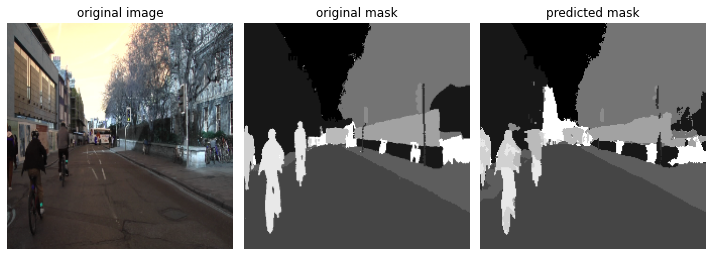

In [37]:
fig, ax = plt.subplots(1,3, figsize=(10,10))
show(im[0].long().permute(1,2,0).detach().cpu(),ax=ax[0],title='original image')
show(mask.permute(1,2,0).detach().cpu(),ax=ax[1],title='original mask')
show( _mask.permute(1,2,0).detach().cpu(),ax=ax[2],title='predicted mask')
plt.tight_layout()
plt.show()
     